# Load Test
This test is supposed to run alongside a LOVE deployment with the following components:
- LOVE-manager
- LOVE-commander
- LOVE-events-producer

The test instantiates a series of fake clients that connect to the LOVE manager and subscribe to events, and a series of emitters that send commands to a Test-CSC which trigger events.
The test calculates events reception latencies on the client side

## Test parameters
Configure number of clients, emitters and other parameters below:

In [1]:
manager_location = 'love-manager:8000'
# Change to line below when running from live environment
# manager_location = 'love-manager-mount:8000'

N_CLIENTS = 50 # Number of clients to simulate
N_EMITTERS = 50 # Number of emitters that will send messages
N_EMITTER_COMMANDS = 50 # Number of commands that each emitter will run

---
## Test execution
### Test setup
Classes necessary for the test

In [2]:
# Most of this was adapted from https://github.com/lsst-ts/ts_salobj/blob/develop/tests/test_csc.py
import asyncio
import json
from lsst.ts import salobj
import logging

STD_TIMEOUT = 15  # timeout for command ack
LONG_TIMEOUT = 30  # timeout for CSCs to start
EVENT_DELAY = 0.1  # time for events to be output as a result of a command
NODATA_TIMEOUT = 0.1  # timeout for when we expect no new data
SHOW_LOG_MESSAGES = False


class FailedCallbackCsc(salobj.TestCsc):
    """A CSC whose do_wait command raises a RuntimeError and whose do_fault command includes a report"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.exc_msg = "do_wait raised an exception on purpose on Test-{}".format(kwargs["index"])
        self.index = kwargs["index"]
        self.log.warning = lambda x: {}
        self.log.info = lambda x: {}
        self.log.error = lambda x: {}
        self.log.debug = lambda x: {}

    async def do_wait(self, data):
        raise RuntimeError(self.exc_msg)

    async def do_fault(self, data):
        """Execute the fault command with a report, code and traceback.
        Change the summary state to State.FAULT
        """
        self.log.warning("Executing fault on Test-{}".format(self.index))
        code = 52
        report = "Report for error code for Test-{}".format(self.index,)
        traceback = "Traceback for error code for Test-{}".format(self.index,)
        self.fault(code=code, report=report, traceback=traceback)


class LogMessagesMock():
    """Triggers logMessages and errorCode events in a TestCSC """

    def __init__(self, salindex, *args, **kwargs):
        self.csc = FailedCallbackCsc(index=salindex, *args, **kwargs)
        d = salobj.Domain()
        self.r = salobj.Remote(d, 'Test', salindex)
        self.salindex = salindex

    async def set_log_level(self):
        await self.r.cmd_setLogLevel.set_start(level=logging.DEBUG, timeout=STD_TIMEOUT)

    def log_info_message(self):
        info_message = "test info message for Test-{}".format(self.salindex,)
        self.csc.log.info(info_message)

    def log_warn_message(self):
        warn_message = "test warn message for Test-{}".format(self.salindex,)
        self.csc.log.warning(warn_message)

    async def log_error_message(self):
        with salobj.assertRaisesAckError():
            await self.r.cmd_wait.set_start(duration=5, timeout=STD_TIMEOUT)

    async def printmessage(self):
        msg = await self.r.evt_logMessage.next(flush=True)
        print('\n TestCSC', self.salindex, ' | msg:', msg.message, '\nlvl:', msg.level, '\ntrace:', msg.traceback)


async def launch(salindex, debug=False):
    mock = LogMessagesMock(salindex, initial_state=salobj.State.ENABLED)
    asyncio.ensure_future(mock.csc.done_task)
    await mock.set_log_level()
    logmessages = [
        mock.log_info_message,
        mock.log_warn_message,
        mock.log_error_message
    ]

    counter = 1

    while True:
        for index, message in enumerate(logmessages):
            if index == 2:
                await message()
            else:
                message()
            if debug:
                while True:
                    try:
                        await mock.printmessage()
                    except asyncio.TimeoutError:
                        break
            counter += 1
            await asyncio.sleep(5)

def create_cscs(number):
    awaitables = []
    loop = asyncio.get_event_loop()
    for salindex in range(1, number+1):
        awaitables.append(loop.create_task(launch(salindex, True)))
    return awaitables

In [3]:
import aiohttp
import json
import asyncio
import requests
from astropy.time import Time

class clientInstance:
    
    def __init__(self):
        self.latencies = []
        self.websocket_url = ''
        self.received_messages = 0
    
    def request_token(self):
        url = f'http://{manager_location}/manager/api/get-token/'
        data = {
            'username': 'test',
            'password': 'test',
        }
        resp = requests.post(url, data = data)
        token = resp.json()['token']
        print(token)
        self.websocket_url = f'ws://{manager_location}/manager/ws/subscription?token={token}'
    
    async def handle_message_reception(self):
        """Handles the reception of messages"""
        if self.websocket:
            async for message in self.websocket:
                if message.type == aiohttp.WSMsgType.TEXT:
                    msg = json.loads(message.data)
                    if 'category' not in msg or msg['category'] != 'event' or "option" in msg and msg["option"] == "subscribe":
                        continue
                    self.received_messages = self.received_messages + 1
                    cur_time = Time.now().tai.datetime.timestamp()
                    snd_time = msg['data'][0]['data']['summaryState'][0]['private_sndStamp']['value']
                    self.latencies.append(cur_time - snd_time)
    
    async def subscribe_to_salindex(self, salindex):
        subscribe_msg = {
            'option': 'subscribe',
            'category': 'event',
            'csc': 'Test',
            'salindex': f'{salindex}',
            'stream': 'summaryState'
        }
        await self.websocket.send_str(json.dumps(subscribe_msg))
    
    async def start_ws_client(self, number):
        async with aiohttp.ClientSession() as session:
            self.websocket = await session.ws_connect(self.websocket_url)
            # async with websockets.connect(websocket_url) as websocket:
            print('started client')
            for i in range(1, N_EMITTERS+1):
                await self.subscribe_to_salindex(i)
                
            await self.handle_message_reception()


In [4]:
from lsst.ts import salobj
import asyncio

class Emitter:
    
    def __init__(self, *args, **kwargs):
        self.salindex = kwargs["salindex"]
        self.emitted_commands = 0
        
    async def create_emitter_task(self):
        d = salobj.Domain()
        r = salobj.Remote(d, 'Test', self.salindex)

        cmds = [
            r.cmd_enable,
            r.cmd_fault,
            r.cmd_standby,
            r.cmd_start,
        ]
        for i in range(N_EMITTER_COMMANDS):
            for command in cmds:
                try:
                    await command.start()
                    self.emitted_commands = self.emitted_commands + 1
                except Exception as e:
                    print('Test CSC error:', e)
                await asyncio.sleep(0.1)
            
def create_emitters(number):
    emitters = []
    for salindex in range(1, number+1):
        emitters.append(Emitter(salindex=salindex))
    return emitters

### Run test
#### Create and launch clients
Clients are created and run, once they start they connect to the LOVE-manager

In [5]:
# Create clients and listen to ws messages
loop = asyncio.get_event_loop()
clients = [clientInstance() for i in range(N_CLIENTS)]
[c.request_token() for c in clients]
client_tasks = [loop.create_task(c.start_ws_client(N_EMITTERS)) for c in clients]

7ebc383b2ea4d976d07bffe30bf58415d237acbe
10b17cad001dfc652fe7cde1a3b7cc53e405e300
0183b9f8b33f84527252273768039c0d63c7626a
a6f89024095205d0d16d1f8646ffe0579e0b5492
5081baeaff0c20635b12bc4de453de8e6eaf2019
929098c7f19e36567a5da3700837559d861a203f
86147e5ba9fa161ba9bec05236d35bd42dba94ff
b0ae8a5d496a46d4481e857dc2cc45e988c2e582
de7eb4cb35caa23ec1573704f7b0766c83c9b7b8
719b5a8704e00a7497c527e8e46557082cd29cff
9833f9e49464fbcd42fbd7822886f2f1d51a735e
0e895301f22eb4b89db37feca8bb2a59ebc44db0
f4240a0a2e0b1b6cc90993fdfa64e6481118e9a3
fefe64b27bb1b41a4d549a960511b2bc6863b568
c03d25e4d98f8dca1a89aec6b829aca7f3668acf
f109cfeb15a943ca17ddc0e4a7f71d082f4c7c6f
d63ab63a96a70fcc8b68d5a4e1aad285a789c89f
d61c9d8949920693f8d8ca05a9cde04a8f480700
e36ee839695eac6b6b4c471355eafe15f81973fd
8769099686d56f1545d3d81307b989b3c06abc98
276aa7cdeec3e1c850ca763bc0c0b9ce6e78a871
63b2e608c4ff287bb39a15e8bd29eeccddcc054f
114b020d64248ace64a2b544aa9258cd27627c77
e26d8babc20369c0e7c16e0465b0e166c7b71953
59098188aa326f1f

#### Create and launch emitters
We wait for 5 seconds, then emitters are created and run.
Once they run they start sending commands (which trigger the events)

In [6]:
# Create emitters and CSCs
import time
time.sleep(5)
loop = asyncio.get_event_loop()
csc_tasks = create_cscs(N_EMITTERS)
emitters = create_emitters(N_EMITTERS)
emitter_tasks = [loop.create_task(e.create_emitter_task()) for e in emitters]

backend_tasks = [*csc_tasks, *emitter_tasks]
# [t.cancel() for t in tasks]
# await asyncio.gather(*tasks)

#### Wait for emitters to end
Wait for emitters to finish their task. This will take a while...

In [7]:
# Wait for emitters
await asyncio.gather(*emitter_tasks)

started client
Test CSC error: msg='Command failed', ackcmd=(ackcmd private_seqNum=322985365, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: enable not allowed in state <State.ENABLED: 2>')
Test CSC error: msg='Command failed', ackcmd=(ackcmd private_seqNum=325220881, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: enable not allowed in state <State.ENABLED: 2>')
Test CSC error: msg='Command failed', ackcmd=(ackcmd private_seqNum=441496821, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: enable not allowed in state <State.ENABLED: 2>')
Test CSC error: msg='Command failed', ackcmd=(ackcmd private_seqNum=389615377, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: enable not allowed in state <State.ENABLED: 2>')
Test CSC error: msg='Command failed', ackcmd=(ackcmd private_seqNum=369662719, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: enable not allowed in state <State.ENABLED: 2>')
Test CSC error: msg='Command failed', ackcmd=

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

---
# Report
Here are the test results

## Summary of received messages

In [8]:
client_msgs = [c.received_messages for c in clients]
emitter_msgs = [e.emitted_commands for e in emitters]
print(f'Sent {sum(emitter_msgs)} messages, received {sum(client_msgs)} messages ({sum(client_msgs)/len(clients)} per client)')

Sent 9950 messages, received 391210 messages (7824.2 per client)


## Latency
### Average and median latency
Here are some latency statistics

In [9]:
import statistics

latencies = [[l*1000 for l in c.latencies] for c in clients]
avg_latencies = [statistics.mean(l) for l in latencies]
median_latencies = [statistics.median(l) for l in latencies]
avg_latency = statistics.mean(avg_latencies)
median_latency = statistics.median(median_latencies)

print(f'Average message latency: {round(avg_latency)}ms')
print(f'Median message latency: {round(median_latency)}ms')


Average message latency: 1259ms
Median message latency: 802ms


### Latencies series
The following chart represents the latencies of each client sorted by reception. That is, the leftmost value was the first message to be received

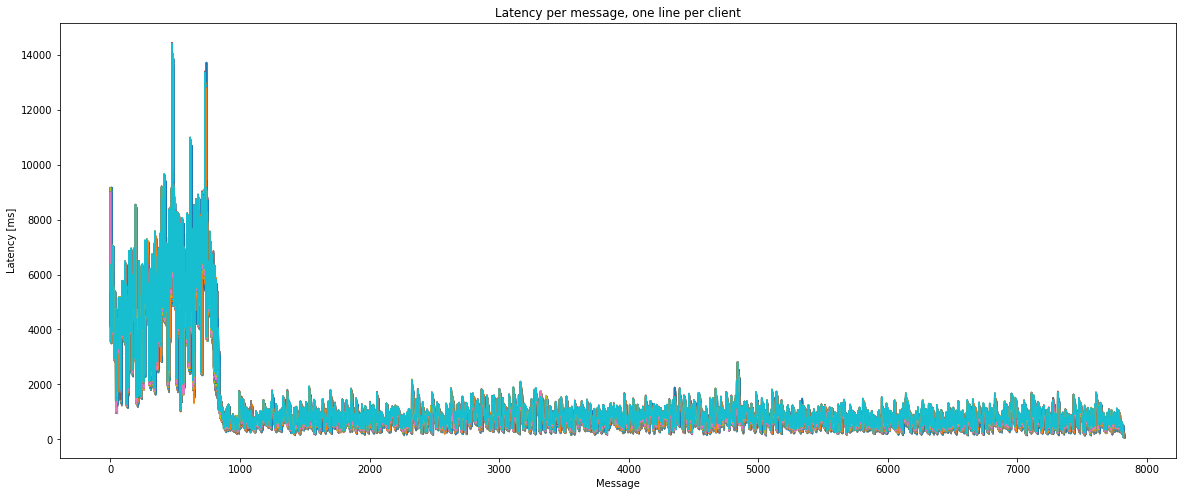

In [10]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
for l in latencies:
    plt.plot(range(len(l)), l)
plt.ylabel('Latency [ms]')
plt.xlabel('Message')
plt.title('Latency per message, one line per client')
plt.show()

In [11]:
import numpy as np
sum(np.array(latencies[0])-np.array(latencies[4]))

83438.64393234253

### Latencies histogram
The following chart represents frequencies of message latencies classified in intervals, despite the client of each message

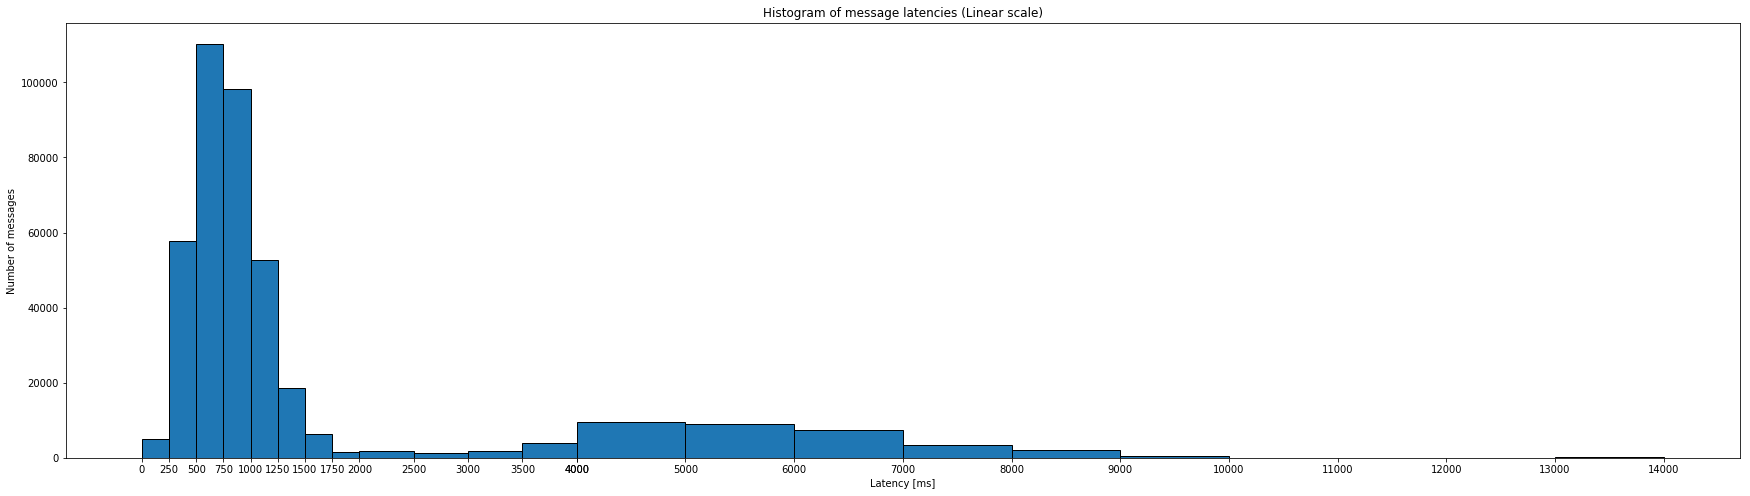

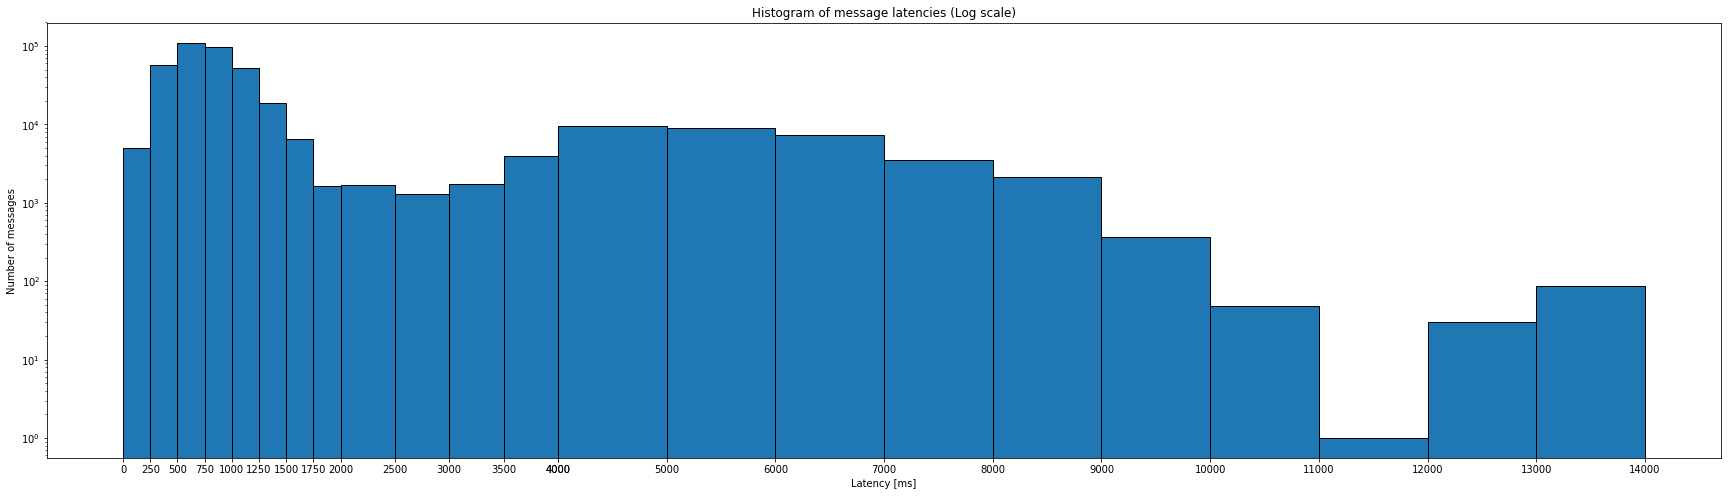

In [28]:
plt.rcParams['figure.figsize'] = [30, 8]
all_latencies = sum(latencies, [])
bins = [x for x in range(0, 2000, 250)] + [x for x in range(2000, 4000, 500)] + [x for x in range(4000, 15000, 1000)]
plt.hist(
    all_latencies,
    bins=bins,
    density=False,
    histtype='bar',
    edgecolor='k',
    log=False,
)
plt.xticks(bins)
plt.xlabel('Latency [ms]')
plt.ylabel('Number of messages')
plt.title('Histogram of message latencies (Linear scale)')
plt.show()

plt.hist(
    all_latencies,
    bins=bins,
    density=False,
    histtype='bar',
    edgecolor='k',
    log=True,
)
plt.xticks(bins)
plt.xlabel('Latency [ms]')
plt.ylabel('Number of messages')
plt.title('Histogram of message latencies (Log scale)')
plt.show()

---
## Test cleanup
Wait for all tasks to end

In [13]:
[t.cancel() for t in [*backend_tasks, *client_tasks]]
#[t.cancel() for t in [*client_tasks]]
for task in asyncio.Task.all_tasks():
    task.cancel()